# Manual for 'Antenna-pointing-model_v3e.py' #

7th  November 2022, Nobuyuki Sakai  
Revised: 17th November 2022

## Purpose ##

Determinations of pointing coefficients via pointing offset measurements with a radio telescope.

## Necessary packages

The python program requires following packages and modules:
- numpy
- matplotlib.pyplot
- csv
- statistics
- scipy.optimize
- lmfit
- emcee
- corner
- progressbar
- io

Please install all the packages and modules (e.g., with pip) before running the python program.

## Basic usage

After editing 'Input_file.txt' and 'Control_v2.txt' as well as preparing an input file with the correct format, please type as

In [1]:
#python Antenna-pointing-model_v3e.py

Please remove '#' when running the python script.

## Input_file.txt

Please specify the name of input file in the 'Input_file.txt'.

Example:

PointingData5.csv #Name of Input file

Please leave the single 'SPACE' before #Name.

The format of the input file is as follows.

Az (deg),El (deg),dAz (arcsec),error_dAz (arcsec),FWHM_az (arcsec),Az (deg),El (deg),dEl (arcsec),error_dEl (arcsec),FWHM_el (arcsec)

- Az_1: Azimuth angle
- El_1: Elevation angle
- dAz: Offset value in azimuth
- error_dAz: error of dAz
- FWHM_az: Full Width at Half Maximum of beam in azimuth
- Az_2: Azimuth angle
- El_2: Elevation angle
- dEl: Offset value in elevation
- error_dEl: error of dEl 
- FWHM_el: Full Width at Half Maximum of beam in elevation

In the python program, azimuth and elevations values are determined by averaging the 1st and 2nd values of Az and El, respectively (i.e., *_1 and *_2).

## Control_v2.txt

The control file is used to remove outlier data from MCMC fitting.

We can define control parameters in the 'Control_v2.txt'.

The format of the Control file is as follows.

- 30.0 #Sigma-clip for Az offset [sigma]
- 30.0 #Sigma-clip for EL offset [sigma]
- 3300.0 #Maximum beam size in Az (arcsec)
- 3300.0 #Maximum beam size in El (arcsec)
- 360.0 #Minimum beam size in Az (arcsec)
- 360.0 #Minimum beam size in El (arcsec)

A data point satisfying following conditions is used for the MCMC fitting:

$$
  \frac{|Az_{{\rm offset}} - {\rm model}|}{{\rm Standard \, Error}} < {\rm Sigma \, clip \, for \, Az \, offset} 
$$

$$
  \frac{|El_{{\rm offset}} - {\rm model}|}{{\rm Standard \, Error}} < {\rm Sigma \, clip \, for \, El \, offset} 
$$

$$
{\rm Minimum \, beam \, size}  < {\rm FWHM}_{{\rm Az}} < {\rm Maximum \, beam \, size}
$$

$$
{\rm Minimum \, beam \, size}  < {\rm FWHM}_{{\rm El}} < {\rm Maximum \, beam \, size}
$$

Note that models for offset values of Az and El are created with the least squares fitting using all data. Model values are subtracted from measurements of offset values, and we calculate (two) standard errors for residuals of Az and EL offset values. 

## Antenna-pointing-model_v3e.py ##

Firstly, we import python packages as

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import statistics
from statistics import stdev
from statistics import median
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import lmfit as lf
from lmfit import Parameter, Parameters, Minimizer
from lmfit import Model,minimize
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
from io import StringIO

Secondly, we define an objective function which is minimized in the least square. 

In [2]:
def func_4_3(theta, X, data2_id:int):
    P1_1, P2_1, P3_1, P4_1, P5_1, P7_2, P4_2, P5_2, P8_2, P9_2  = ( theta['P1_1'], theta['P2_1'],
                                                                  theta['P3_1'], theta['P4_1'], theta['P5_1'],
                                                                  theta['P7_2'], theta['P4_2'], theta['P5_2'],
        							  theta['P8_2'], theta['P9_2'] )
    if data2_id == 1:
        return delta_Az2(P1_1, P2_1, P3_1, P4_1, P5_1, X)
    if data2_id == 2:
        return delta_El2(P7_2, P4_2, P5_2, P8_2, P9_2, X)


In [3]:
def objective_3(theta, X:np.ndarray, data2:np.ndarray, uncertainty2:np.ndarray):
    # make residual per data set
    residual = 0.0 * data2
    for n in range(data2.shape[0]):
        residual[n] = ( data2[n] - func_4_3(theta, X, n+1) ) / uncertainty2[n]
    # now flatten this to a 1D array, as minimize() needs
    return residual.flatten()


Thirdly, we define a likelihood function which is used for MCMC (Markov chain Monte Carlo) analysis.

In [4]:
def log_likelihood_5(theta, X:np.ndarray, data2:np.ndarray, uncertainty2:np.ndarray):
    scale_az,scale_el  = (theta['scale_az'],theta['scale_el'])
    El_deg = X[1]
    El_rad = El_deg * np.pi / 180.0
    model_az   = func_4_3(theta, X, 1)
    model_el   = func_4_3(theta, X, 2)
    sigma_az   = uncertainty2[0] ** 2 * (scale_az) ** 2 
    sigma_el   = uncertainty2[1] ** 2 * (scale_el) ** 2 
    return  ( -0.5 *  ( np.sum((data2[0] - model_az) ** 2 / sigma_az + np.log(2 * np.pi * sigma_az ))
                      + np.sum((data2[1] - model_el) ** 2 / sigma_el + np.log(2 * np.pi * sigma_el )) ) )


In the above likelihood function, we inserted scale factors as

$$
  n_{{\rm Az}} \times {\rm (Errors \, of \, Az \, offset \, values)} 
$$

and 
$$
  n_{{\rm El}} \times {\rm (Errors \, of \, El \, offset \, values).}
$$

Using the scale factors, we assume that 'relative errors of offset values' are correct. If 'absolute errors' are wrong, all errors are multiplied by a scale factor.

In [5]:
# Prior function
# def log_prior_5(theta):
    #sys_az, sys_el  = theta['sys_az'], theta['sys_el']
    #return - np.log(sys_az) - np.log(sys_el)

Regarding priors (i.e., our knowledge about model parameters), we assume flat priors for all model parameters. After we accumulate experiences and pointing measurements, we will update priors.

Lastly, we define posterior which consists of the likelihood and priors.

In [5]:
def log_posterior_5(theta, X:np.ndarray, data2:np.ndarray, uncertainty2:np.ndarray):
    #lp = log_prior_5(theta)
    #if not np.isfinite(lp):
    #    return -np.inf
    return log_likelihood_5(theta, X, data2, uncertainty2)

### Antenna pointing model

By referring to [P. de Vicente, 2007](https://www.researchgate.net/publication/267369881_Deconstructing_a_pointing_model_for_the_40M_OAN_radiotelescope), we define functions (i.e., subroutines) which model offset values of azimuth and elevation.

For a Nasmyth antenna, models for offset values of azimuth and elevation are expressed as

$$
\Delta Az = 𝑃_{1}+𝑃_{2}{\rm sec}𝐸𝑙+𝑃_{3}{\rm tan}𝐸𝑙 - 𝑃_{4}{\rm cos}(𝐴𝑧){\rm tan}𝐸𝑙 + 𝑃_{5}{\rm sin}(𝐴𝑧){\rm tan}𝐸𝑙
$$

and

$$
\Delta El = 𝑃_{7} + 𝑃_{4}{\rm sin}𝐴𝑧 {\color{red}+} 𝑃_{5}{\rm cos}𝐴𝑧 + 𝑃_{8}{\rm sin}𝐸𝑙 + 𝑃_{9}{\rm cos}𝐸𝑙. \label{a}\tag{1}
$$

**Note that the sign of $P_{5}$ is plus (+) in Eq. (1), which is different from [the original document](https://www.researchgate.net/publication/267369881_Deconstructing_a_pointing_model_for_the_40M_OAN_radiotelescope). We directly contacted the PI of the document and confirmed that the plus is correct.**

Physical meaning of pointing coefficients ($P_{1}$ to $P_{9}$) for a Nasmyth is shown in the following Table. 

| Parameter | Physical meaning |
| --- | --- | 
| $P_{1}$ | Azimuth encoder offset. If positive the antenna always points towards larger azimuth values.<br> This term also includes positioning errors for receivers in the Nasmyth focus. |
| $P_{2}$ | Collimation error. It includes positioning errors for Nasmyth mirrors. |
| $P_{3}$ | Lack of orthogonality between the azimuth and elevation axis. If positive both axis form an <br>angle smaller than 90$^{\circ}$. This term also includes positioning errors for receivers in the Nasmyth focus. |
| $P_{4}$ | Tilt of azimuth axis along a E-W direction. If positive the axis is tilted towards the East.  |
| $P_{5}$ | Tilt of azimuth axis along a N-S direction. If positive the axis is tilted towards the South. |
| $P_{7}$ | Elevation encoder offset. If positive the antenna always points towards higher elevations.<br> It also includes positioning errors for Nasmyth mirrors. |
| $P_{8}$ | Gravitational effects. It also includes positioning errors for receivers in the Nasmyth focus. |
| $P_{9}$ | Gravitational effects. It also includes positioning errors for receivers in the Nasmyth focus. |

We define subroutines for the above equations.

In [6]:
def deg_rad_az(X):
    Az_deg = X[0]
    Az_rad = Az_deg * np.pi / 180.0
    return Az_rad


In [7]:
def deg_rad_el(X):
    El_deg = X[1]
    El_rad = El_deg * np.pi / 180.0
    return El_rad

In [8]:
def collimation_term(X):
    El_rad = deg_rad_el(X)
    collimation = 1.0/np.cos(El_rad)
    return collimation

In [9]:
def orthogonality_term(X):
    El_rad = deg_rad_el(X)
    orthogonality = np.tan(El_rad)
    return orthogonality

In [10]:
def tilt_east(X):
    Az_rad = deg_rad_az(X)
    El_rad = deg_rad_el(X)
    tilt_East = -1.0 * np.cos(Az_rad) * np.tan(El_rad)
    return tilt_East

In [11]:
def tilt_south(X):
    Az_rad = deg_rad_az(X)
    El_rad = deg_rad_el(X)
    tilt_South = np.sin(Az_rad) * np.tan(El_rad)
    return tilt_South

In [12]:
def delta_Az2(P1, P2, P3, P4, P5, X):
    return ( P1 + P2 * collimation_term(X)
                     + P3 * orthogonality_term(X)
                     + P4 * tilt_east(X)
		     + P5 * tilt_south(X) )


In [13]:
def tilt_east_south(X):
    Az_rad = deg_rad_az(X)
    tilt_East_South = 1.0 * np.sin(Az_rad)
    return tilt_East_South

In [14]:
def tilt_south_east(X):
    Az_rad = deg_rad_az(X)
    #tilt_South_East = -1.0 * np.cos(Az_rad) #Typo in original document
    tilt_South_East = +1.0 * np.cos(Az_rad)  #
    return tilt_South_East

In [15]:
def gravitation_term1(X):
    El_rad = deg_rad_el(X)
    gravitation_1 = np.sin(El_rad)
    return gravitation_1

In [16]:
def gravitation_term2(X):
    El_rad = deg_rad_el(X)
    gravitation_2 = np.cos(El_rad)
    return gravitation_2

In [17]:
def delta_El2(P7, P4, P5, P8, P9, X):
    return ( P7 + P4 * tilt_east_south(X)
                     + P5 * tilt_south_east(X)
                     + P8 * gravitation_term1(X)
		     + P9 * gravitation_term2(X) )


## The least-squares fitting

We load an input file. **The following data is mock data which obeys Gaussian distributions with an 1𝜎 error of 100 arcsec, except for outliers.**

**We added 10 outliers which have an 1$\sigma$ error of 500 arcsec, rather than 100 arcsec into the mock data.**

In [66]:
with open("Input_file.txt") as f:
    content = f.read().replace(' #Name of Input file\n', '')

In [67]:
print("Input file:%s"% content)

Input file:Mock-data-v8b.dat


In [76]:
#Data = np.loadtxt(content, comments="#",delimiter=',',skiprows=1)
Data = np.genfromtxt(content, comments="Az",delimiter=',')

When loading the input file, a row is skipped if the row starts with the string 'Az'. 

Also, a row in the input file is skipped if the row starts with the string ',,,,,,,,,'.

In [77]:
Az = []
El = []
dAz_error = []
dEl_error = []
d_Az = []
d_El = []
line = 1

for i in Data:
    if ( (str(i[0]) == "nan") or (str(i[1]) == "nan") or (str(i[2]) == "nan") or
         (str(i[3]) == "nan") or (str(i[4]) == "nan") or (str(i[5]) == "nan") or
         (str(i[6]) == "nan") or (str(i[7]) == "nan") or (str(i[8]) == "nan") or
         (str(i[9]) == "nan") ):
        line = line + 1
        print('The line %d is skipped'% line)
    else:
       Az.append((float(i[0])+float(i[5]))/2.0)
       El.append((float(i[1])+float(i[6]))/2.0)
       dAz_error.append(float(i[3]))
       dEl_error.append(float(i[8]))
       d_Az.append(float(i[2]))
       d_El.append(float(i[7]))
       line = line + 1

In [78]:
num = len(d_Az)+len(d_El)
print('The number of all data:%d'% num)

The number of all data:400


As shown above, 400 data points are loaded.

**Note that we separately count offset values of Az and El. In other words, we have 400/2 = 200 pairs of (dAz, dEl).**

We fit antenna pointing models to offset values of Az and EL with the weighted least squares using the Python package [lmfit](https://lmfit.github.io/lmfit-py/).

In [79]:
Az_deg = np.array(Az)
El_deg = np.array(El)
X = np.array([Az_deg,El_deg])
d_Az = np.array(d_Az)
d_El = np.array(d_El)
dAz_error = np.array(dAz_error)
dEl_error = np.array(dEl_error)
data2 = np.array([d_Az,d_El])
uncertainty2 = np.array([dAz_error,dEl_error])

In [80]:
fit_params2 = lf.Parameters()

In [81]:
fit_params2.add("P1_1", value=0.1)
fit_params2.add("P2_1", value=0.1)
fit_params2.add("P3_1", value=0.1)
fit_params2.add("P4_1", value=-0.2)
fit_params2.add("P5_1", value=0.1)
fit_params2.add("P7_2", value=-0.1)
fit_params2.add("P4_2", value=-0.2)
fit_params2.add("P5_2", value=0.1)
fit_params2.add("P8_2", value=1.0)
fit_params2.add("P9_2", value=-1.0)

In [47]:
fit_params2[f'P4_2'].expr = f'P4_1'
fit_params2[f'P5_2'].expr = f'P5_1'
fit_params2

name,value,initial value,min,max,vary,expression
P1_1,0.10000000,0.1,-inf,inf,True,
P2_1,0.10000000,0.1,-inf,inf,True,
P3_1,0.10000000,0.1,-inf,inf,True,
P4_1,-0.20000000,-0.2,-inf,inf,True,
P5_1,0.10000000,0.1,-inf,inf,True,
P7_2,-0.10000000,-0.1,-inf,inf,True,
P4_2,-0.20000000,-0.2,-inf,inf,False,P4_1
P5_2,0.10000000,0.1,-inf,inf,False,P5_1
P8_2,1.00000000,1.0,-inf,inf,True,
P9_2,-1.00000000,-1.0,-inf,inf,True,


As shown in the above Table, we do not make any restrictions for the search range of model parameters.

Also, we define that the same pointing coefficients (i.e., $P_{4}$ and $P_{5}$) are used in two models for offset values of azimuth and those of elevation.

In [82]:
result2 = lf.minimize(objective_3, params=fit_params2, args=(X, data2, uncertainty2),scale_covar=True)

In [83]:
print(lf.fit_report(result2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 400
    # variables        = 10
    chi-square         = 4722.79193
    reduced chi-square = 12.1097229
    Akaike info crit   = 1007.47635
    Bayesian info crit = 1047.39099
[[Variables]]
    P1_1:  509.387112 +/- 46.8649161 (9.20%) (init = 0.1)
    P2_1: -129.981737 +/- 79.1360383 (60.88%) (init = 0.1)
    P3_1:  78.4087014 +/- 73.0479145 (93.16%) (init = 0.1)
    P4_1: -10.2565954 +/- 6.22190210 (60.66%) (init = -0.2)
    P5_1:  12.3581853 +/- 5.77107662 (46.70%) (init = 0.1)
    P7_2:  439.354915 +/- 178.239619 (40.57%) (init = -0.1)
    P4_2: -7.95884205 +/- 17.3107781 (217.50%) (init = -0.2)
    P5_2:  8.96213135 +/- 17.7542282 (198.10%) (init = 0.1)
    P8_2: -315.627539 +/- 141.479955 (44.82%) (init = 1)
    P9_2: -286.389108 +/- 134.327833 (46.90%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(P2_1, P3_1) = -0.997
    C(P7_2, P8_2) = -0.986
    C

We show true values and the results of the least squares in the following table.

| Parameter | True values | Least Squares |
| --- | --- | --- | 
| $P_{1}$ | 500 | 509$\pm$47|
| $P_{2}$ | $-$141 | $-$130$\pm$79|
| $P_{3}$ | 94 | 78$\pm$73|
| $P_{4}$ | $-$16| $-$10$\pm$6|
| $P_{5}$ | 13| 12$\pm$6|
| $P_{7}$ | 500| 439$\pm$178|
| $P_{8}$ | $-$400| $-$316$\pm$141|
| $P_{9}$ | $-$300| $-$286$\pm$134|

**The results of the least-squares fitting are consistent with true values within errors.**

We output text file including the results of the least-squares fitting.

In [84]:
f = open('Least-squares.txt', 'w')
f.write(lf.fit_report(result2))
f.close()

## Flagging outlier data

Based on the control file and the results of the least squares fitting, we clip data which is generally deviate from a pointing model.

In [85]:
###################
# Calculation of stndard errors for (delta_az - model ) and (delta_el - model)
#####################
num_Az = len(d_Az)
num_El = len(d_El)
d_Az_se   = stdev(d_Az-func_4_3(result2.params, X, 1))/np.sqrt(num_Az)
d_El_se   = stdev(d_El-func_4_3(result2.params, X, 2))/np.sqrt(num_El)

In [86]:
Control = np.loadtxt('Control_v2.txt', comments="#")

clip_d_Az = Control[0]
clip_d_El = Control[1]
az_fwhm = Control[2]
el_fwhm = Control[3]
az_min_fwhm = Control[4]
el_min_fwhm = Control[5]

Data2 = np.genfromtxt(content, comments="Az",delimiter=',')

In [87]:
Az = []
El = []
dAz_error = []
dEl_error = []
d_Az = []
d_El = []
Az_flag = []
El_flag = []
d_Az_flag = []
d_El_flag = []
dAz_error_flag = []
dEl_error_flag = []
output_flag = []
line = 1

for i in Data2:
    if ( (str(i[0]) == "nan") or (str(i[1]) == "nan") or (str(i[2]) == "nan") or
         (str(i[3]) == "nan") or (str(i[4]) == "nan") or (str(i[5]) == "nan") or
         (str(i[6]) == "nan") or (str(i[7]) == "nan") or (str(i[8]) == "nan") or
         (str(i[9]) == "nan") ):
        line = line + 1
        print('The line %d is skipped'% line)
    else:
         if ( np.abs( ( float(i[2]) - func_4_3(result2.params, [float(i[0]),float(i[1])], 1) ) /
                  (d_Az_se)  )
                  < clip_d_Az and np.abs( ( float(i[7]) - func_4_3(result2.params, [float(i[0]),float(i[1])], 2) ) /
                  (d_El_se) )
                  < clip_d_El and (np.abs(float(i[4])) ) < (az_fwhm) and
                  (np.abs(float(i[9])) ) < (el_fwhm) and (np.abs(float(i[4])) ) > (az_min_fwhm) and
                  (np.abs(float(i[9])) ) > (el_min_fwhm)):
            Az.append((float(i[0])+float(i[5]))/2.0)
            El.append((float(i[1])+float(i[6]))/2.0)
            dAz_error.append(float(i[3]))
            dEl_error.append(float(i[8]))
            d_Az.append(float(i[2]))
            d_El.append(float(i[7]))
            line = line + 1 
         else:
            Az_flag.append((float(i[0])+float(i[5]))/2.0)
            El_flag.append((float(i[1])+float(i[6]))/2.0)
            d_Az_flag.append(float(i[2]))
            d_El_flag.append(float(i[7]))
            dAz_error_flag.append(float(i[3]))
            dEl_error_flag.append(float(i[8]))
            line = line + 1
            #print('The line %d is clipped'% line)
            output_flag.append([line,float(i[0]),float(i[1]),float(i[2]),float(i[3])
                           ,float(i[4]),float(i[5]),float(i[6]),float(i[7])
                           ,float(i[8]),float(i[9])])

We output clipped data.

In [88]:
f = open('Output_flag.txt', 'w')
f.write('#line number, Az (deg),El (deg),dAz (arcsec),error_dAz (arcsec),FWHM_az (arcsec),Az (deg),El (deg),dEl (arcsec),error_dEl (arcsec),FWHM_el (arcsec) ')
for x in output_flag:
    f.write(str(x) + "\n")


f.close()

In [89]:
flag = len(Az_flag)+len(El_flag)
print('The number of all data:%d'% num)
print('The number of flagged data:%d'% flag)

The number of all data:400
The number of flagged data:14


14 data points are clipped from 400 data points.

If the filtered data still contain outlier, please modify the control file and run the Python script again.

### MCMC analysis

To update antenna pointing coefficients, we conduct MCMC (Markov chain Monte Carlo) fitting using the Python package [emcee](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract). 

In [90]:
Az_deg = np.array(Az)
El_deg = np.array(El)
X = np.array([Az_deg,El_deg])
d_Az = np.array(d_Az)
d_El = np.array(d_El)
dAz_error = np.array(dAz_error)
dEl_error = np.array(dEl_error)
data2 = np.array([d_Az,d_El])
uncertainty2 = np.array([dAz_error,dEl_error])

Az_flag = np.array(Az_flag)
El_flag = np.array(El_flag)
dAz_error_flag = np.array(dAz_error_flag)
dEl_error_flag = np.array(dEl_error_flag)
X2 = np.array([Az_flag,El_flag])
d_Az_flag = np.array(d_Az_flag)
d_El_flag = np.array(d_El_flag)

In [91]:
nwalkers = 100  # number of MCMC walkers
nburn =  1600    # "burn-in" period to let chains stabilize
nsteps = 8000   # number of MCMC steps to take
thin =   100

In [92]:
emcee_params = result2.params.copy()
emcee_params.add('scale_az', value=0.1, min=0, max=1000)
emcee_params.add('scale_el', value=0.1, min=0, max=1000)

We introduce scaling factors by which errors of azimuth and elevation offsets are multiplied.

In [93]:
mini2 = Minimizer(log_posterior_5, emcee_params, fcn_args=(X, data2, uncertainty2))
res = mini2.emcee(burn=nburn,steps=nsteps, nwalkers=nwalkers,thin=thin,is_weighted=True,progress=True,float_behavior='posterior')

100%|██████████████████████████████████████████████████████| 8000/8000 [16:08<00:00,  8.26it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 160;
tau: [435.26680054 452.80928918 448.58076402 102.58053698 157.74992674
 401.5803738   56.15152247 115.76867531 407.14223563 392.3064282
 514.61864782 109.15103042]


The above values (autocorrelation time) mean that walkers require up to ~515 steps to forget initial values.

We show MCMC fitting results.

In [94]:
print('median of posterior probability distribution')
print('--------------------------------------------')                                   
lf.report_fit(res.params)

median of posterior probability distribution
--------------------------------------------
[[Variables]]
    P1_1:      534.007944 +/- 27.1483936 (5.08%) (init = 509.3871)
    P2_1:     -185.308072 +/- 45.8292201 (24.73%) (init = -129.9817)
    P3_1:      130.831048 +/- 41.9927977 (32.10%) (init = 78.4087)
    P4_1:     -9.76619268 +/- 3.55894469 (36.44%) (init = -10.2566)
    P5_1:      13.3528873 +/- 3.29816385 (24.70%) (init = 12.35819)
    P7_2:      478.499273 +/- 114.441739 (23.92%) (init = 439.3549)
    P4_2:     -0.75592795 +/- 11.0336184 (1459.61%) (init = -7.958842)
    P5_2:     -16.4066089 +/- 11.4076127 (69.53%) (init = 8.962131)
    P8_2:     -373.744388 +/- 90.6210453 (24.25%) (init = -315.6275)
    P9_2:     -297.338732 +/- 85.8212561 (28.86%) (init = -286.3891)
    scale_az:  1.99100622 +/- 0.10340803 (5.19%) (init = 0.1)
    scale_el:  2.16593238 +/- 0.11093492 (5.12%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(P2_1, P3_1) = -0.997
    C(

**Note that initial values (i.e., init) are consistent with the results of the least-squares fitting.**

We show true values and both results of the least squares and MCMC in the following table.

| Parameter | True values | Least Squares | MCMC |
| --- | --- | --- | --- | 
| $P_{1}$ | 500 | 509$\pm$47| 534$\pm$27|
| $P_{2}$ | $-$141 | $-$130$\pm$79| $-$185$\pm$46|
| $P_{3}$ | 94 | 78$\pm$73| 131$\pm$42|
| $P_{4}$ | $-$16| $-$10$\pm$6| $-$10$\pm$4|
| $P_{5}$ | 13| 12$\pm$6| 13$\pm$3|
| $P_{7}$ | 500| 439$\pm$178| 478$\pm$114|
| $P_{8}$ | $-$400| $-$316$\pm$141| $-$374$\pm$91|
| $P_{9}$ | $-$300| $-$286$\pm$134| $-$297$\pm$86|
| $n_{Az}$ | 2.0| $-$| 2.0$\pm$0.1|
| $n_{El}$ | 2.0| $-$| 2.2$\pm$0.1|

We calculate statistical indexes (i.e., Reduced chi-square; AIC; BIC) for the results of the MCMC fitting.

In [95]:
#########################################
# Caclulation of the reduced chi-square, AIC and BIC
########################################
k = 10 # The number of model parameters
Az_term     =  (d_Az-func_4_3(res.params, X, 1))**2 / ( (res.params['scale_az'])**2 * uncertainty2[0]**2 )
Az_term_sum = np.sum( (d_Az-func_4_3(res.params, X, 1))**2 / ( (res.params['scale_az'])**2 * uncertainty2[0]**2))
Sigma_az    = ( (res.params['scale_az'])**2 * uncertainty2[0]**2 )
El_term     =  (d_El-func_4_3(res.params, X, 2))**2 / ( (res.params['scale_el'])**2 * uncertainty2[1]**2)
El_term_sum = np.sum( (d_El-func_4_3(res.params, X, 2))**2 / ( (res.params['scale_el'])**2 * uncertainty2[1]**2))
Sigma_el    = ( (res.params['scale_el'])**2 * uncertainty2[1]**2)
Reduced_chi_square = (Az_term_sum + El_term_sum)/((num-flag)-k)

In [96]:
Az_aic = -2 * ( -0.5 * np.sum( Az_term + np.log(2 * np.pi * Sigma_az) ) )
El_aic = -2 * ( -0.5 * np.sum( El_term + np.log(2 * np.pi * Sigma_el) ) )
AIC = Az_aic + El_aic + 2 * k
BIC = Az_aic + El_aic + k * np.log((num-flag))
                                   
print('Reduced chi-square:%.2f'% Reduced_chi_square)
print('AIC:%.1f'% AIC)
print('BIC:%.1f'% BIC)

Reduced chi-square:0.99
AIC:4686.8
BIC:4726.3


We output text file including the results of the MCMC fitting.

In [97]:
f = open('MCMC.txt', 'w')
f.write('reduced chi-square:%.2f\n'% Reduced_chi_square)
f.write('AIC:%.1f\n'% AIC)
f.write('BIC:%.1f\n'% BIC)
f.write(lf.fit_report(res.params))
f.close()

## Making plots

To evaluate pointing measurements (i.e., offset values of Az and El) as well as the MCMC fitting, we make various plots.

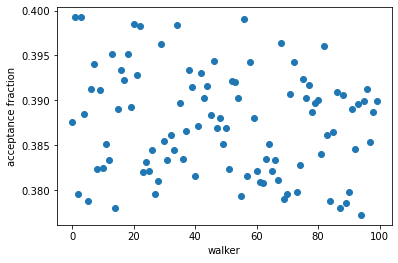

<Figure size 432x288 with 0 Axes>

In [98]:
plt.plot(res.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.savefig("Acceptance-fraction.png")
plt.show()
plt.clf()

Acceptance fraction is the fraction of proposed steps that are accepted. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 ([Foreman-Mackey et al. 2013](https://iopscience.iop.org/article/10.1086/670067)).

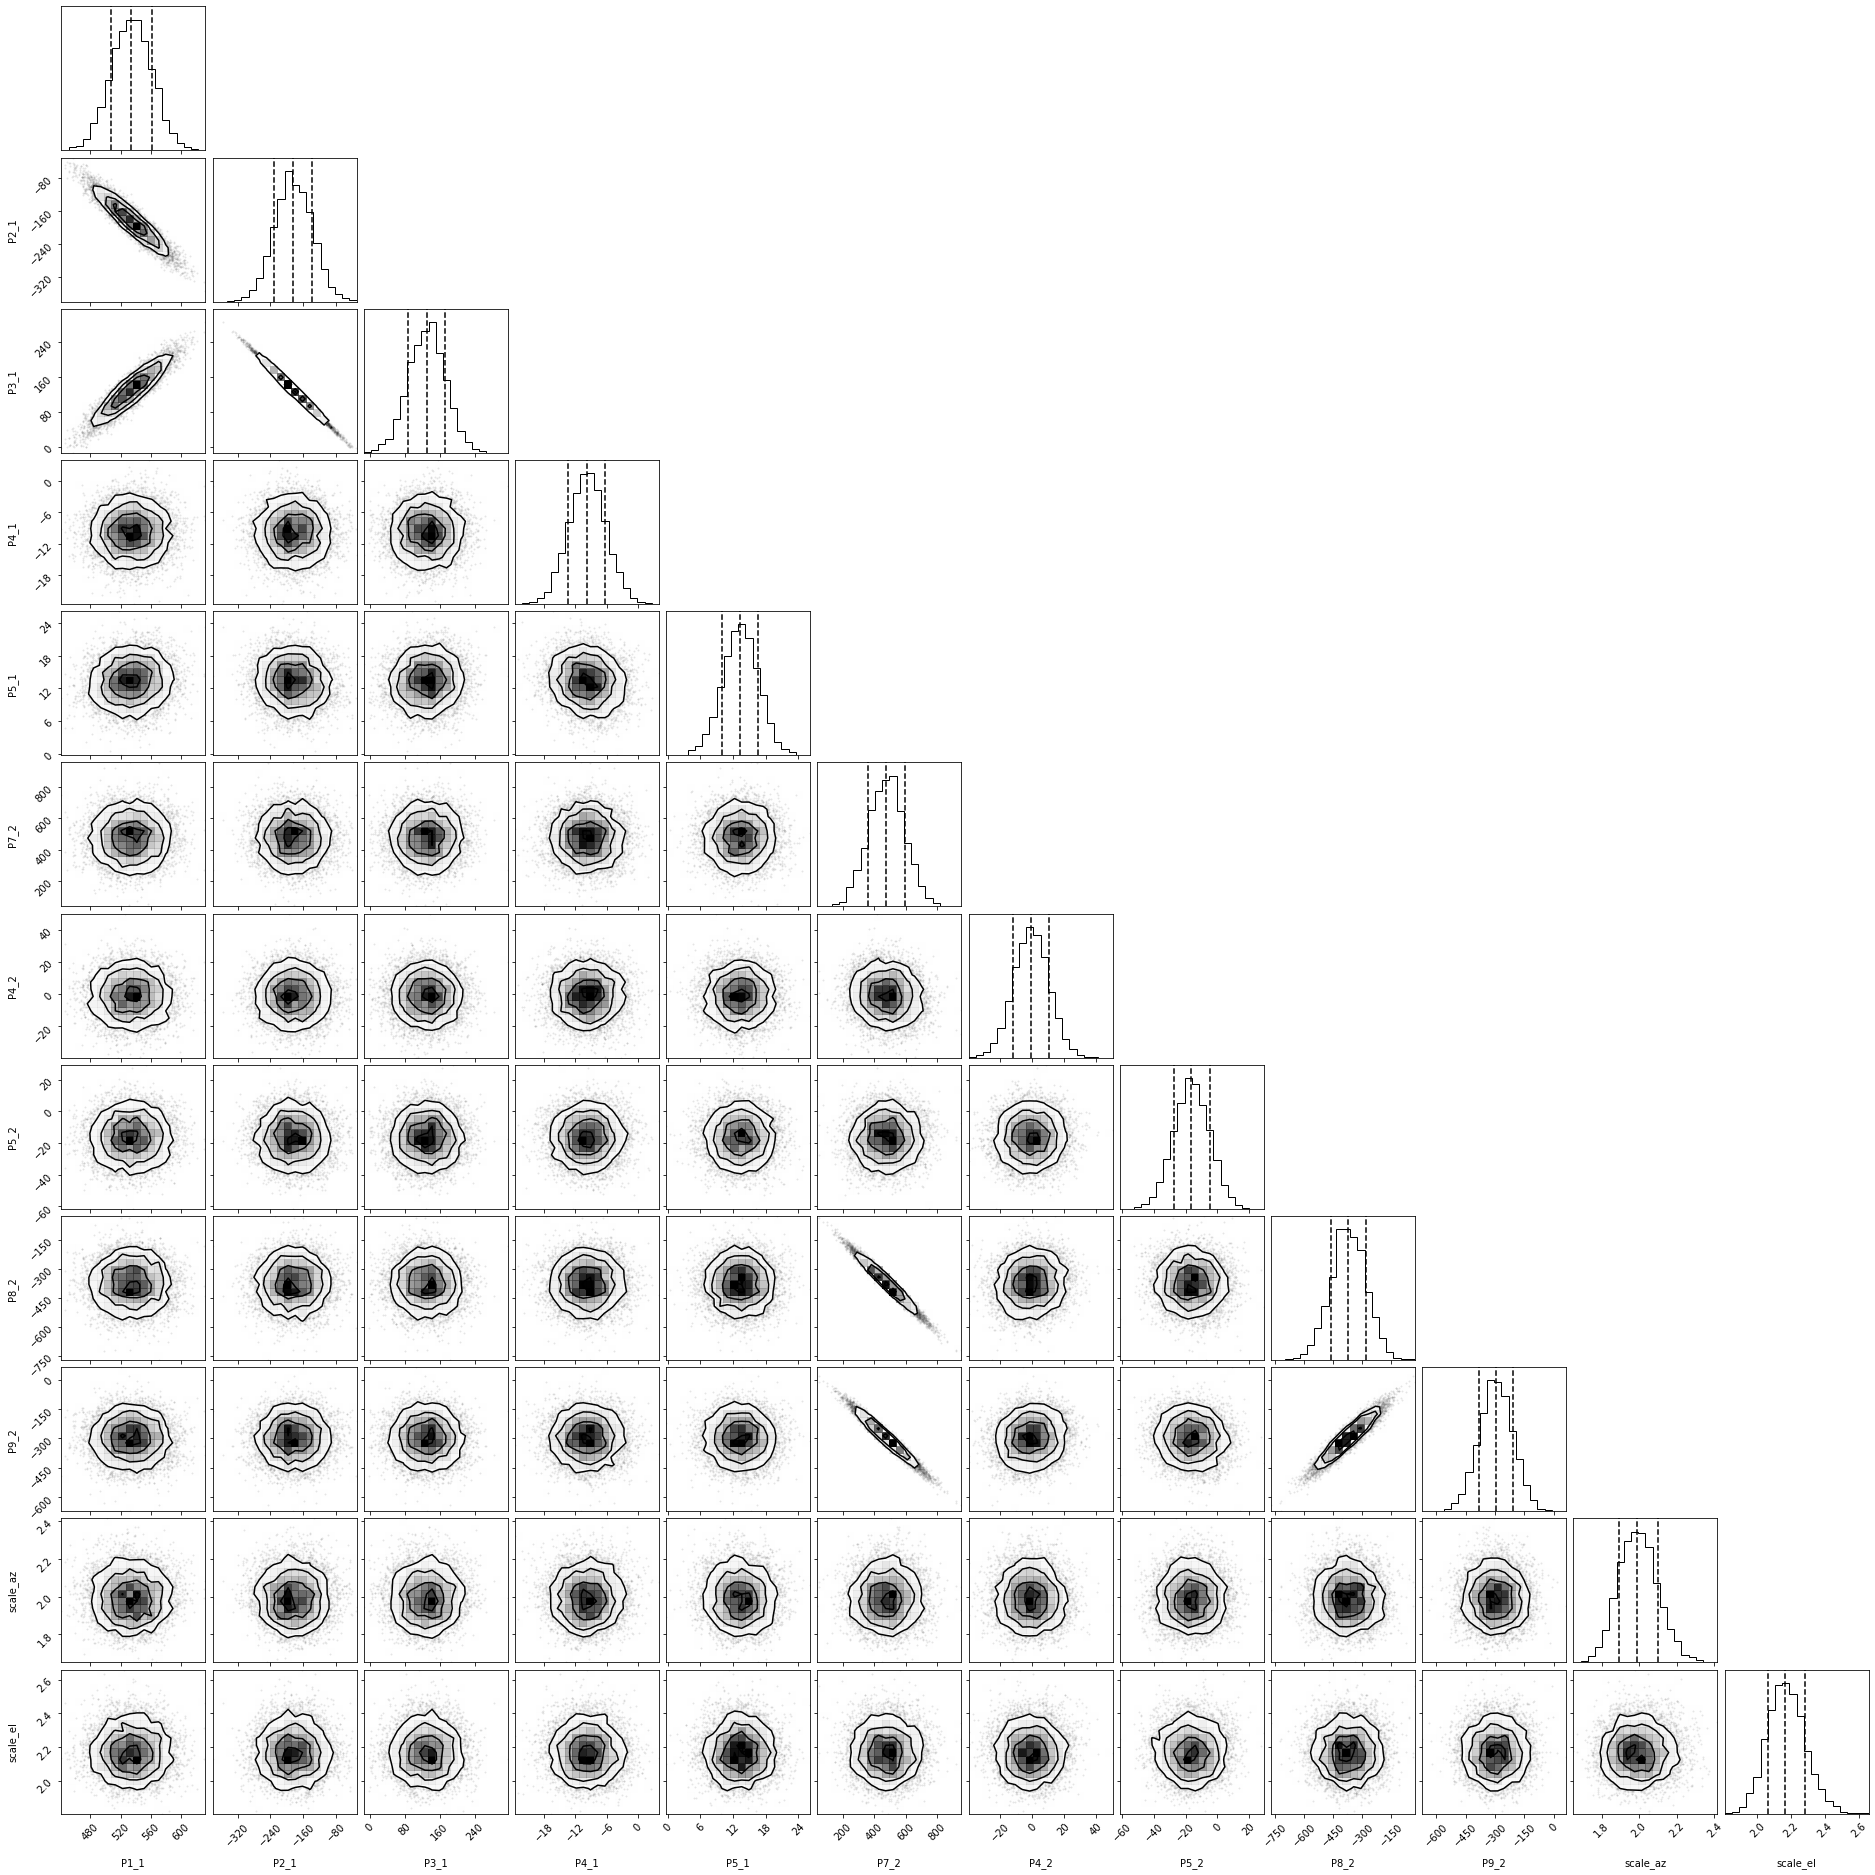

<Figure size 432x288 with 0 Axes>

In [99]:
import corner
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,quantiles=[0.15865, 0.5, 0.84135])

plt.savefig("Posteriors.png")
plt.show()
plt.clf()

The corner plot shows posterior probability distributions for individual model parameters. Vertical dashed lines show the 16th, 50th, and 84th percentiles of samples for individual model parameters. We can see tight correlations in some combinations of model parameters. 

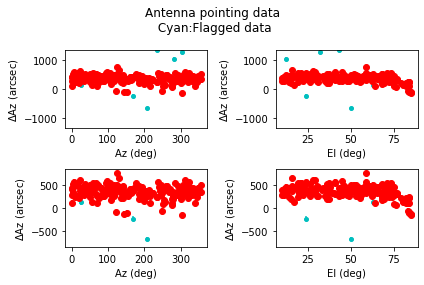

<Figure size 432x288 with 0 Axes>

In [100]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Antenna pointing data\n Cyan:Flagged data',fontsize=12)

max_min=np.max([np.abs(d_Az_flag)])
ax[0,0].set_ylim([-max_min,max_min])

ax[0,0].errorbar(Az_flag,d_Az_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[0,0].errorbar(Az,d_Az,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[0,0].set_ylabel('$\Delta$Az (arcsec)')
ax[0,0].set_xlabel('Az (deg)')
ax[0,0].tick_params(labelsize=10)

max_min=np.max([np.abs(d_Az)])
ax[1,0].set_ylim([-1.1*max_min,1.1*max_min])

ax[1,0].errorbar(Az_flag,d_Az_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[1,0].errorbar(Az,d_Az,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,0].set_ylabel('$\Delta$Az (arcsec)')
ax[1,0].set_xlabel('Az (deg)')
ax[1,0].tick_params(labelsize=10)
#Margin
plt.subplots_adjust(hspace=0.45)

# El vs. d_Az
max_min=np.max([np.abs(d_Az_flag)])
ax[0,1].set_ylim([-max_min,max_min])

ax[0,1].errorbar(El_flag,d_Az_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[0,1].errorbar(El,d_Az,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[0,1].set_ylabel('$\Delta$Az (arcsec)')
ax[0,1].set_xlabel('El (deg)')
ax[0,1].tick_params(labelsize=10)

max_min=np.max([np.abs(d_Az)])
ax[1,1].set_ylim([-1.1*max_min,1.1*max_min])

ax[1,1].errorbar(El_flag,d_Az_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[1,1].errorbar(El,d_Az,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,1].set_ylabel('$\Delta$Az (arcsec)')
ax[1,1].set_xlabel('El (deg)')
ax[1,1].tick_params(labelsize=10)
plt.tight_layout()
plt.savefig("d_Az.png")
plt.show()
plt.clf()
















Red shows data which are used for the MCMC fitting, while cyan data are not used for the fitting.

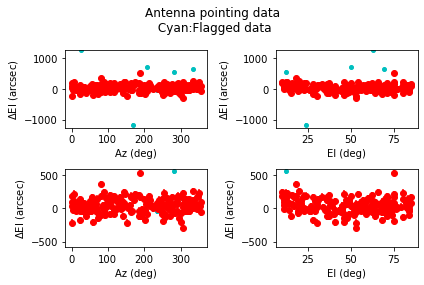

<Figure size 432x288 with 0 Axes>

In [101]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Antenna pointing data\n Cyan:Flagged data',fontsize=12)

max_min=np.max([np.abs(d_El_flag)])
ax[0,0].set_ylim([-max_min,max_min])

ax[0,0].errorbar(Az_flag,d_El_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[0,0].errorbar(Az,d_El,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[0,0].set_ylabel('$\Delta$El (arcsec)')
ax[0,0].set_xlabel('Az (deg)')
ax[0,0].tick_params(labelsize=10)

max_min=np.max([np.abs(d_El)])
ax[1,0].set_ylim([-1.1*max_min,1.1*max_min])

ax[1,0].errorbar(Az_flag,d_El_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[1,0].errorbar(Az,d_El,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,0].set_ylabel('$\Delta$El (arcsec)')
ax[1,0].set_xlabel('Az (deg)')
ax[1,0].tick_params(labelsize=10)

#Margin
plt.subplots_adjust(hspace=0.45)

# El vs. d_El
max_min=np.max([np.abs(d_El_flag)])
ax[0,1].set_ylim([-max_min,max_min])

ax[0,1].errorbar(El_flag,d_El_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[0,1].errorbar(El,d_El,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[0,1].set_ylabel('$\Delta$El (arcsec)')
ax[0,1].set_xlabel('El (deg)')
ax[0,1].tick_params(labelsize=10)
max_min=np.max([np.abs(d_El)])
ax[1,1].set_ylim([-1.1*max_min,1.1*max_min])

ax[1,1].errorbar(El_flag,d_El_flag,yerr=dAz_error_flag,fmt=".c", capsize=0,markersize=8)
ax[1,1].errorbar(El,d_El,yerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,1].set_ylabel('$\Delta$El (arcsec)')
ax[1,1].set_xlabel('El (deg)')
ax[1,1].tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("d_El.png")
plt.show()
plt.clf()
















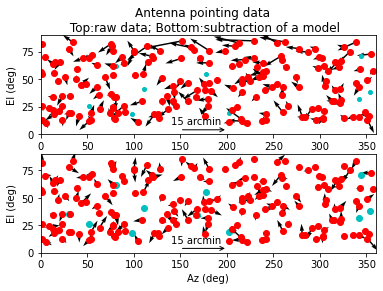

<Figure size 432x288 with 0 Axes>

In [61]:
fig, ax = plt.subplots(2,1)
fig.suptitle('Antenna pointing data\n Top:raw data; Bottom:subtraction of a model')

ax[0].errorbar(Az_flag,El_flag, fmt=".c", capsize=0,markersize=8)
ax[0].errorbar(Az,El, fmt=".r", capsize=0,markersize=12)

ax[0].set_ylabel('El (deg)')
ax[0].set_ylim([0,90])
ax[0].set_xlim([0,360])

if np.max([d_Az,d_El]) > 180.0:
      ax[0].quiver(Az,El,d_Az,d_El,angles='xy',scale_units='xy',scale=18.0,color='black')
      ax[0].text(140, 9, "15 arcmin")
else:
      ax[0].quiver(Az,El,d_Az,d_El,angles='xy',scale_units='xy',scale=3.6,color='black')
      ax[0].text(140, 9, "3 arcmin")

x1 = 200 #Endpoint of x
y1 = 4 #Endpoint of y

x2 = 150 #Start of x
y2 = 4 #Start of y

xy = (x1,y1)
xytext = (x2,y2)

ax[0].annotate("" , xy=xy , xytext=xytext , arrowprops=dict(arrowstyle='->',facecolor="black",edgecolor="black") )

ax[1].errorbar(Az_flag,El_flag, fmt=".c", capsize=0,markersize=12)
ax[1].errorbar(Az,El, fmt=".r", capsize=0,markersize=12)
ax[1].set_ylabel('El (deg)')
ax[1].set_xlabel('Az (deg)')
if np.max([d_Az,d_El]) > 180.0:
      ax[1].quiver(Az,El,d_Az-func_4_3(res.params, X, 1),d_El-func_4_3(res.params, X, 2),angles='xy',scale_units='xy',scale=18.0,color='black')
      ax[1].text(140, 9, "15 arcmin")
else:
      ax[1].quiver(Az,El,d_Az-func_4_3(res.params, X, 1),d_El-func_4_3(res.params, X, 2),angles='xy',scale_units='xy',scale=3.6,color='black')
      ax[1].text(140, 9, "3 arcmin")



ax[1].set_ylim([0,90])
ax[1].set_xlim([0,360])

ax[1].annotate("" , xy=xy , xytext=xytext , arrowprops=dict(arrowstyle='->',facecolor="black",edgecolor="black") )


plt.savefig("Az-El.png")
plt.show()
plt.clf()











Arrows in the above plots show offset values. By subtracting a pointing model from offset values, the length of arrows is decreased in the bottom plot.

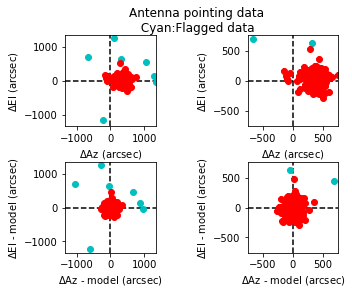

<Figure size 432x288 with 0 Axes>

In [102]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Antenna pointing data\n Cyan:Flagged data')

ax[0,0].errorbar(d_Az_flag,d_El_flag, yerr=dEl_error_flag,xerr=dAz_error_flag,fmt=".c", capsize=0,markersize=12)
ax[0,0].errorbar(d_Az,d_El,yerr=dEl_error,xerr=dAz_error, fmt=".r", capsize=0,markersize=12)

ax[0,0].set_ylabel('$\Delta$El (arcsec)')
ax[0,0].set_xlabel('$\Delta$Az (arcsec)')
ax[0,0].set_aspect('equal')
ax[0,0].axhline(0.0, ls='--', color='black')
ax[0,0].axvline(0.0, ls='--', color='black')
max_min=np.max([np.abs(d_Az_flag),np.abs(d_El_flag)])
ax[0,0].set_ylim([-max_min,max_min])
ax[0,0].set_xlim([-max_min,max_min])

ax[0,1].errorbar(d_Az_flag,d_El_flag, yerr=dEl_error_flag,xerr=dAz_error_flag,fmt=".c", capsize=0,markersize=12)
ax[0,1].errorbar(d_Az,d_El,yerr=dEl_error,xerr=dAz_error, fmt=".r", capsize=0,markersize=12)

ax[0,1].set_ylabel('$\Delta$El (arcsec)')
ax[0,1].set_xlabel('$\Delta$Az (arcsec)')
ax[0,1].set_aspect('equal')
ax[0,1].axhline(0.0, ls='--', color='black')
ax[0,1].axvline(0.0, ls='--', color='black')
max_min=np.max([np.abs(d_Az),np.abs(d_El)])
ax[0,1].set_ylim([-max_min,max_min])
ax[0,1].set_xlim([-max_min,max_min])

#Margin
plt.subplots_adjust(hspace=0.4)

ax[1,0].errorbar(d_Az_flag-func_4_3(res.params, X2, 1),d_El_flag-func_4_3(res.params, X2, 2), yerr=dEl_error_flag,xerr=dAz_error_flag,fmt=".c", capsize=0,markersize=12)
ax[1,0].errorbar(d_Az-func_4_3(res.params, X, 1),d_El-func_4_3(res.params, X, 2), yerr=dEl_error,xerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,0].set_ylabel('$\Delta$El - model (arcsec)')
ax[1,0].set_xlabel('$\Delta$Az - model (arcsec)')
ax[1,0].axhline(0.0, ls='--', color='black')
ax[1,0].axvline(0.0, ls='--', color='black')
ax[1,0].set_aspect('equal')
max_min=np.max([np.abs(d_Az_flag),np.abs(d_El_flag)])
ax[1,0].set_ylim([-max_min,max_min])
ax[1,0].set_xlim([-max_min,max_min])

ax[1,1].errorbar(d_Az_flag-func_4_3(res.params, X2, 1),d_El_flag-func_4_3(res.params, X2, 2), yerr=dEl_error_flag,xerr=dAz_error_flag,fmt=".c", capsize=0,markersize=12)
ax[1,1].errorbar(d_Az-func_4_3(res.params, X, 1),d_El-func_4_3(res.params, X, 2), yerr=dEl_error,xerr=dAz_error,fmt=".r", capsize=0,markersize=12)
ax[1,1].set_ylabel('$\Delta$El - model (arcsec)')
ax[1,1].set_xlabel('$\Delta$Az - model (arcsec)')
ax[1,1].axhline(0.0, ls='--', color='black')
ax[1,1].axvline(0.0, ls='--', color='black')
ax[1,1].set_aspect('equal')
max_min=np.max([np.abs(d_Az),np.abs(d_El)])
ax[1,1].set_ylim([-max_min,max_min])
ax[1,1].set_xlim([-max_min,max_min])


plt.savefig("d_Az-d_El.png")
plt.show()
plt.clf()











Pointing results show that offset values deviate from zero value in the upper panels. Our aim is to determine pointing coefficients so that pointing results distribute around the zero value.

We can see that pointing offset values in azimuth and elevation distribute around the zero value in the lower panels.

**We calculate mean, standard deviation, and standard error for data which are used for the MCMC fitting.**

In [103]:
d_Az_mean = np.mean(d_Az)
d_Az_stdev = stdev(d_Az)
d_El_mean = np.mean(d_El)
d_El_stdev = stdev(d_El)
d_Az_mean_res = np.mean(d_Az-func_4_3(res.params, X, 1))
d_Az_stdev_res   = stdev(d_Az-func_4_3(res.params, X, 1))
d_El_mean_res = np.mean(d_El-func_4_3(res.params, X, 2))
d_El_stdev_res   = stdev(d_El-func_4_3(res.params, X, 2))

In [104]:
print('Mean, standard deviation and (standard error)')
print('d_Az:','{:.3g}'.format(d_Az_mean),'+/-','{:.3g}'.format(d_Az_stdev),'(','{:.3g}'.format(d_Az_stdev/(np.sqrt(num-flag))),')','arcsec')
print('d_El:','{:.3g}'.format(d_El_mean),'+/-','{:.3g}'.format(d_El_stdev),'(','{:.3g}'.format(d_El_stdev/(np.sqrt(num-flag))),')','arcsec')
print('d_Az - model:','{:.3g}'.format(d_Az_mean_res),'+/-','{:.3g}'.format(d_Az_stdev_res),'(','{:.3g}'.format(d_Az_stdev_res/(np.sqrt(num-flag))),')','arcsec')
print('d_El - model:','{:.3g}'.format(d_El_mean_res),'+/-','{:.3g}'.format(d_El_stdev_res),'(','{:.3g}'.format(d_El_stdev_res/(np.sqrt(num-flag))),')','arcsec')

Mean, standard deviation and (standard error)
d_Az: 355 +/- 137 ( 6.96 ) arcsec
d_El: 36.4 +/- 113 ( 5.73 ) arcsec
d_Az - model: 0.531 +/- 98.1 ( 4.99 ) arcsec
d_El - model: 0.332 +/- 107 ( 5.43 ) arcsec


Standard deviations of Az and EL offset values are decreased to 98 and 107 arcsec, respectively after subtracting pointing models from the offset values. An assumed error for Az and EL offset values, 100 arcsec, is almost consistent with the final standard deviations of Az and El offset values.

## References

- P. de Vicente, 2007, [Deconstructing a pointing model for the 40M OAN
radio telescope](https://www.researchgate.net/publication/267369881_Deconstructing_a_pointing_model_for_the_40M_OAN_radiotelescope), OAN Technical Report: IT-OAN 2007-26.

-  Foreman-Mackey, Daniel ; Hogg, David W. ; Lang, Dustin ; Goodman, Jonathan, [emcee: The MCMC Hammer](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract), Publications of the Astronomical Society of the Pacific, Volume 125, Issue 925, pp. 306 (2013).

- Python package '[lmfit](https://lmfit.github.io/lmfit-py/index.html)' for Non-Linear Least-Squares Minimization and Curve-Fitting for Python